# Quantum K-means algorithm for image clustering

In this Jupyter Notebook a version of the K-means algorithm that uses a quantum circuit to compute the distance between two points is implemented. The quantum K-means algorithm is going to cluster $n$ points into $k$ different groups based on the Euclidean distance between points and centroids, which is calculated with a quantum circuit. When implemented classically the distance calculation can become computationally heavy as the complexity of the dataset increases. 

In this notebook, we use satellite data as an example of a big dataset that can be heavy to iterate through. The satellite data is from the EuroSAT dataset and it contains satellite images in RBG format [[1]](#references). The data has been classically preprocessed in a separate notebook called "DataPreparation", where you can find more details about the preprocessing steps and what is represented by the points we are clustering. Alternatively, you can generate your own data using Scikit-learn's make_blobs or choose another dataset.

Two different functions are created for the distance calculations. One is made specifically for the five qubit Finnish quantum computer Helmi and the other one is designed to be a general function that can handle any number of qubits and be run on any machine.

The steps in this notebook will be the following:
1. Providing background information about the algorithm

2. Importing the necessary libraries and preparing the quantum backend

3. Creating a function to encode data into qubits

4. Making a function to compute the distance between points using a quantum circuit

5. Implementing the rest of the K-means algorithm classically, including cluster initialization, centroid updates, and cluster assignments

6. Running our algorithm and obtaining results from a quantum computer or a simulator

7. Comparing the performance of our algorithm with Scikit-learn's K-means algorithm

## 1. Background information about the algortihm

K-means is an unsupervised machine learning algorithm that takes $n$ vectors and divides them into $k$ groups [[2,3]](#references). The clustering is done by calculating the distance between a vector and each of the cluster centroids and assigning the vector to the nearest cluster. This is repeated for every vector. After each vector has been assigned to a cluster, new centroids are determined based on the mean of the vectors in a cluster. Now, the distances between the vectors and the new centroids are calculated and a vector is possibly moved to a new closer cluster. This is repeated until the centroids of the clusters do not change after computing the mean of the cluster. The issue in classical k-means is that the algorithm becomes computationally heavy once the number of vectors, clusters or the dimension of the the vectors increase. The heaviest part of the k-means is calculating the distance between each vector and cluster centroid [[3]](#references). According to [[3]](#references) the time complexity of this is $O(Nnk)$, where $N$ is the number of features in the vector, $n$ is the number of vectors, and $k$ is the number of clusters.

To minimize the time complexity a qauntum computer, like Helmi the Finnish quantum computer from the Finnish Quantum-Computing Infrastructure (FiQCI), could be used to perform some of the steps in the k-means algorithm. In this notebook the distance calculation is done with a quantum circuit. Otherwise the algorithm will be using classical implementations for cluster assignement and updating the centroids. The steps in implementning the quantum algorithm include encoding the vectors into the qubits and building the quantum circuit that computes the distance. The feature encoding is done by amplitude encoding and the distance calculation is done with the swap test. These are methods that Dawid Kopczyk presents in [[2]](#references) and according to [[3]](#references) the time complexity of this implementation of quantum k-means is $O(log(N)nk)$. Both the amplitude encoding and the swap test will be presented in detail later in this notebook.

## 2. Necessary imports and backend preparation
To begin, the needed libraries are imported and the qauntum backends are prepared. 

You can choose to use a noise free simulator like Qiskit Aer, a noisy simulator or a real quantum computer. In this example, the noisy simulator is the IQMFakeAdonis which has a noise profile corresponding to the Helmi Quantum computer. Note that the amount of qubits is then limited to 5. The real quantum computer in this example, is Helmi. Note that this requires access to the quantum computer and the qubits are again limited to 5.

In [1]:
# The libraries for the classical part of the algorithm
import os
from sklearn.datasets import make_blobs
import numpy as np
import matplotlib.pyplot as plt
import math
from math import pi
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import KMeans
import pandas as pd
from collections import Counter
import random
from PIL import Image

# The libraries for the quantum part of the algorithm
from qiskit import Aer, transpile
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from iqm.qiskit_iqm import IQMProvider, IQMFakeAdonis
from iqm.qiskit_iqm import optimize_single_qubit_gates
from qiskit.circuit.library import StatePreparation

In [2]:
## CHOOSE BACKEND HERE
# You can run this example on any of the following backends
#backend_id = 'Helmi'
backend_id = 'FakeAdonis'    # Fake Helmi simulator
#backend_id = 'statevector_simulator'

# Helmi
if (backend_id == 'Helmi'):
    HELMI_CORTEX_URL = os.getenv('HELMI_CORTEX_URL')
    provider = IQMProvider(HELMI_CORTEX_URL)
    backend = provider.get_backend()

# Noisy simulator of Helmi 
if (backend_id == 'FakeAdonis'):
    backend = IQMFakeAdonis()

# ideal simulator
if (backend_id == 'statevector_simulator'):
    backend = Aer.get_backend('statevector_simulator')

# You can check the native gates of the backend, not necessary to use only them the transpiling of the circuit takes care of that
print(backend.operation_names)

['r', 'id', 'cz', 'measure']


## 3. Amplitude encoding function

In this section, a method for encoding data into qubits is presented. In order to use a quantum circuit for clustering or any other machine learningn task the data needs to be represented by the qubits. To do so, one can choose a method of data encoding. There exist many different options for example angle encoding and amplitude encoding. In this example we will be using amplitude encoding. This means that the vector that is encoded is normalized and the points from it are used as amplitudes of the initial state of the quantum circuit. Amplitude encoding has been presented for exmaple in [[2]](#references) and in this notebook we are going to create the state vectors $\ket{\phi}$ and $\ket{\psi}$ similarly.

The information from a vector A can be encoded as:

$\ket{A} = \sum_{i=1}^{N} \left|A\right|^{-1} A_i \ket{i}$

Then, two quantum states are initialized as:

$\ket{\phi} = \frac{1}{\sqrt{Z}} \left(|A|\ket{0} + |B|\ket{1}\right)$, where $Z = |A|^2 + |B|^2$

$\ket{\psi} = \frac{1}{\sqrt{2}} \left(\ket{0,A} + \ket{1,B}\right)$

The state vector $\phi$ will alway have one qubit and the state vector $\psi$ has qubits depending on its length which is dependent on the number of dimension in the data.

The following function is used to create the state vectors $\phi$ and $\psi$ that are used to initialize the quantum states in the distance calculation circuit. 

In [3]:
# Amplitude encoding of the data
def get_phi_psi(A, B):
    # Calculating the normalization coefficient for A and B
    sum_A = sum(a**2 for a in A)
    sum_B = sum(b**2 for b in B)

    A_norm = math.sqrt(sum_A)
    B_norm = math.sqrt(sum_B)
    Z = A_norm**2 + B_norm**2

    # creating phi and psi states
    phi = [A_norm/math.sqrt(Z), B_norm/math.sqrt(Z)]
    psi = []
    for i in range(len(A)):
        psi.append(((A[i] / A_norm) / math.sqrt(2)))
        psi.append(((B[i] / B_norm )/ math.sqrt(2)))

    # Ensuring that the statevector is a power of 2
    # The state vector needs to have the correct length corresponding to the number of qubits
    next_power_of_2 = 2 ** math.ceil(math.log2(len(psi)))
    while len(psi) < next_power_of_2:
        psi.append(0)
    
    return phi, psi, Z

## 4. Creating a function to compute the distance between points with a quantum circuit

Now that the data is stored into the state vectors $\phi$ and $\psi$ they can be used to build the quantum circuit. In this notebook we use the Euclidean distance to determine how far the vectors are from each other. The distance between the points A and B can be defined with the swap test. The swap test expresses the overlap of two states $\braket{\phi|\psi}$. The overlap can be calculated with the probability of the control qubit being in state $\ket{0}$. [[2]](#references) uses the swap test for the implementation of the quantum k-means algorithm and it has been presented for the first  time in [[4]](#references). The general circuit for the swap test can bee seen in the Figure 1 below:

![Circuit Diagram](Circuit.png)

Figure 1 : The circuit diagram of the swap test. Here $\ket{\phi}$ has one qubit allocated to it and $\ket{\psi}$ has $\log_2{l}$ number of qubits, where $l$ is the length of the state vector $\psi$.

When measuring the ancilla qubit, the outcome is $0$ with probablitiy $1$ if the states $\ket{\phi}$ and $\ket{\psi}$ are identical and more generally the measured outcome is 0 with probability $\frac{1}{2}+\frac{1}{2}|\braket{\phi|\psi}|^2$. Which is an estimator of the fidelity, $Fid(\ket{\psi}, \ket{\phi}) = |\braket{\phi|\psi}|^2$, that describes the probability that one quantum state will be identified as the other, in other words how close the quantum states are to each other.

To get the Euclidean distance between two quantum states from the swap test circuit, the following euqations and steps, also presented in [[2]](#references), can be used.

1. Probability of measuring $\ket{0}$:

   $P(\ket{0}) = |\frac{1}{2}\braket{0|0}(\ket{\phi, \psi} + \ket{\psi, \phi})+\frac{1}{2}\braket{0|1}(\ket{\phi, \psi} - \ket{\psi, \phi})|^2$ (the steps to get to the next equation can be found in [[2]](#references))

   $P(\ket{0}) = \frac{1}{2} + \frac{1}{2}|\braket{\phi|\psi}|^2$ <- here we have the fidelity present, which represents the overlap of the two states.

   $|\braket{\psi|\phi}|^2 = 2P(\ket{0})-1$ , the probability of getting the $\ket{0}$ can be obtained from the counts of '0' from the measurement divided by the number of shots.

2. The Euclidean distance between two vectors, A and B: 

   It is given by $||A-B||$, which can be expressed as $||A-B||^2 = |A-B|^2$

   And $|A-B|^2 = \sqrt{(A-B)(A-B)}^2$

   Let's compute the expression for $(A-B)$

   $\braket{\phi|\psi} = \frac{1}{\sqrt{Z}}(|A|\bra{0}+ |B|\bra{1}) \cdot \frac{1}{\sqrt{2}}(\ket{0,A}\ket{1,B})$

   $ = \frac{1}{\sqrt{2Z}}(|A|\ket{A} + |B|\ket{B})$

   The encoding of the classical information allows the inner product to be expressed as:

   $\braket{\phi|\psi} = \frac{1}{\sqrt{2Z}}(A-B)$, from this we get that $(A-B) = \sqrt{2Z}\braket{\phi|\psi} $

   Thus we get:

   $|A-B|^2 = \sqrt{\sqrt{2Z}\braket{\phi|\psi} \cdot \sqrt{2Z}\braket{\phi|\psi}}^2$

   $|A-B|^2 = 2Z|\braket{\phi|\psi}|^2$

   This and the probability from earlier can now be combined as:

   $|A-B|^2 = 2Z \cdot (2P(\ket{0})-1)$

   And the Euclidean distance will be:

   $||A-B|| = \sqrt{|A-B|^2} = \sqrt{2Z \cdot (2P(\ket{0})-1)}$

Thus, the Euclidean distance between vectors A and B can be calculated with a quantum circuit. The next cell will have the functions "get_Distance" and "get_Distance_general" that will be used to compute the distance between two vectors. The function "get_Distance" is designed to work on the Helmi quantum computer as it uses only 5 qubits and initializes the quantum states without the Qiskit function "initialize". "get_Distance_general" on the other hand uses initialize and it can be used for as many qubits as needed.

In [4]:
# Two different fucntions for getting the Euclidean distance, if the code is run on Helmi for data that has one or two features use get_Distance
# and if you want to run it for more complicated data that requires more qubits use get_Distance_general
def get_Distance(x,y):
    # Using the amplitude encoding function to store the features in the states
    phi, psi, Z = get_phi_psi(x,y)
    phi = np.array(phi) / np.linalg.norm(phi)
    psi = np.array(psi) / np.linalg.norm(psi)

    # Preparations for the quantum circuit
    num_qubits = 5
    # Third qubit is ancilla (see Helmi layout)
    ancilla_index = 2

    qr = QuantumRegister(num_qubits, name='qr')
    cr = ClassicalRegister(1, name='cr')
    qc = QuantumCircuit(qr, cr, name='k_means')

    # Intitializing the quantum states with the state vectors
    # Append is used as Helmi does not have "reset" in its native gates and the Qiskit function "initialize" uses it
    qc.append(StatePreparation(phi, normalize=False), [0])
    qc.append(StatePreparation(psi, normalize=False), [1])

    # Initializing the ancilla qubit
    qc.h(ancilla_index)
    # The swap test to compute the similarity between the two points/vectors
    qc.cswap(ancilla_index, 0, 1)
    # Superposition away from ancilla
    qc.h(ancilla_index)
    # Measure ancilla
    qc.measure(ancilla_index, 0)

    # Running the circuit and getting the results
    transpiled = transpile(qc, backend, optimization_level=3, seed_transpiler=1)
    optimized = optimize_single_qubit_gates(transpiled, backend)
    shots = 1024.0
    job = backend.run(optimized, shots=shots)
    result = job.result()
    data = result.get_counts()

    # Calculating the quantum distance
    x = abs((2*data['0']/shots - 1) * 2 * Z)
    Q_dist = math.sqrt(x)
    
    return Q_dist

    
def get_Distance_general(x, y):
    # Using the amplitude encoding function to store the features in the states
    phi, psi, Z = get_phi_psi(x,y)
    phi = np.array(phi) / np.linalg.norm(phi)
    psi = np.array(psi) / np.linalg.norm(psi)

    # Preparations for the quantum circuit
    num_psi = int(np.ceil(np.log2(len(psi))))
    num_qubits = num_psi +2                    # we need one more qubit to be the ancilla and psi 

    qr = QuantumRegister(num_qubits, name='qr')
    cr = ClassicalRegister(1, name='cr')
    qc = QuantumCircuit(qr, cr, name='k_means')

    # Intitializing the quantum states with the state vectors
    qc.initialize(phi,1)
    qc.initialize(psi, list(range(2, num_psi+2)))
    # Initializing the ancilla qubit
    qc.h(0)
    # The swap test to compute the similarity between the two points/vectors
    qc.cswap(0,1,2)
    # Superposition away from ancilla
    qc.h(0)
    # Measure ancilla
    qc.measure(0, 0)
    # Running the circuit and getting the results
    transpiled = transpile(qc, backend, seed_transpiler=1)
    shots = 1024
    job = backend.run(transpiled, shots=shots)
    result = job.result()
    data = result.get_counts()
    # Calculating the quantum distance
    x = abs((2*data['0']/shots - 1) * 2 * Z)
    Q_dist = math.sqrt(x)

    return Q_dist


## 5. Implementing the rest of the K-means algorithm classically

The rest of the K-means algorithm is implemented classically. This includes the step of initializing the centers, finding the nearest neighbor by classifying the points based on their distance to the centers, and updating the centroids so that the algorithm can converge into the best clustering result. A fuction for plotting the data and the results of the clustering is also created.

In [5]:
# A function to scatter plot the data points
def plotting(points, labels, label=True):
    labels = np.array(labels)

    if points.shape[1] == 1:
        if label==False:
            plt.scatter(points, labels)
        else : 
            plt.scatter(points, labels, c=labels, cmap='viridis')
    else :
        if label==False:
            plt.scatter(points[:,0], labels)
        else :
            plt.scatter(points[:,0], labels, c=labels, cmap='viridis')
    plt.xlim(points.min() - 1, points.max() + 1)
    plt.ylim(labels.min() - 1, labels.max() + 1)
    plt.title('Quantum K-Means Clustering')
    plt.xlabel('Feature')
    plt.ylabel('Label')
    plt.show()

In [6]:
# Initializing the centers
# This is the first random guess where the centers could be
def initial_centers(points,k):
    return points[np.random.randint(points.shape[0],size=k),:]

In [7]:
# A function to find the closest cluster to a vector. It takes as parameters the points which is the data that is going to be clusteres and the current centroids. 
# Then for each point the distance to each cluster is calculated. When the smallest distance is found that label is saved in the array pred_labels
def find_nearest_cluster(points, centroids):
    n = len(points)
    k = centroids.shape[0]
    pred_labels = np.zeros(n, dtype=int)

    for i in range(n):
        minimum_distance = float('inf')
        cluster_label = -1
        for j in range(k):
            p = points[i]
            c = centroids[j]
            temp_dis = get_Distance(p,c)
            if temp_dis < minimum_distance:
                minimum_distance = temp_dis
                cluster_label = j
        if cluster_label == -1:
            raise ValueError(f"No valid centroid found for point {i}")
        pred_labels[i] = cluster_label

    return pred_labels

In [8]:
# A function for updating the centroids based on the mean of the vectors belonging into that cluster
def get_centroids(points, pred_labels):
    k = int(np.max(pred_labels))+1
    centroids = np.zeros((k, points.shape[1]))

    for i in range(k):
        if np.sum(pred_labels == i) == 0:
            centroids[i, :] = points[np.random.randint(points.shape[0])]
        else :
            centroids[i, :] = np.mean(points[pred_labels == i], axis=0)

    return centroids

## 6. Running our algorithm and getting the results from a quantum computer or a simulator

Now that all of the functions that we need are defined, the quantum K-means algorithm can be run. The first part is getting our data that we want to cluster. Then the closest cluster for each point is found and the cluster centroids are updated. This part is run as many times as necessary. Ideal situation is that the cluster centroids do not change after the "get_centroids" is run. Sometimes this can take a while so a for loop has been chosen so that the running time of the algorithm can be modified. (Note that a different number of iterations might change the clustering results) 

After the for loop the predicted cluster labels are mapped with the actual labels to evaluate how well they correspond to each other. The evaluation is done with the  Adjusted Rand Index (ARI), from Scikit-learn, that ranges between $-0.5$ and $1$, where $1$ is perfect clustering, $0$ is random clustering, and $-0.5$ is worse clustering than random. 

The ARI score is defined as [[5]](#references):

$ARI = \frac{RI - ExpectedRI}{maximum(RI) - ExpectedRI}$

where $RI = \frac{TP + TN}{TP + FP + FN + TN}$

The $RI$ is the adjusted rand index that is defined with true positives ($TP$ ), true negatives ($TN$), false positives($FP$), and false negatives ($FN$).

The clustered points are also visualized with a scatter plot and some example images from each cluster are plotted.

In [9]:
# A function to create data for clustering if the notebook DataPreparation has not been used inorder to work with the satellite data.

def get_data(n,k):
    points, original_centers = make_blobs(n_samples=n, n_features=2, centers=k, random_state=100)
    return points, original_centers

# If the gat_data function is used use the following to get your data for clustering and comment out the ones in the next cell
# The values are examples and can be changed
#k = 2
#n = 100
#points, original_centers = get_data(n,k)
#labels = original_centers

/Users/mmakital/opt/miniconda3/envs/projectenv/lib/python3.10/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/mmakital/opt/miniconda3/envs/projectenv/lib/python3.10/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


0
Iteration 0:
Centroids:
[[-3.43605093]
 [11.83528653]]
Unique labels: [0 1]
1
Iteration 1:
Centroids:
[[ 11.09391988]
 [-11.78014173]]
Unique labels: [0 1]
2
Iteration 2:
Centroids:
[[-11.46467375]
 [ 11.46467375]]
Unique labels: [0 1]
3
Iteration 3:
Centroids:
[[ 11.46467375]
 [-11.46467375]]
Unique labels: [0 1]
4
Iteration 4:
Centroids:
[[-11.2366918 ]
 [ 11.69533228]]
Unique labels: [0 1]
5
Iteration 5:
Centroids:
[[ 11.46467375]
 [-11.46467375]]
Unique labels: [0 1]
6
Iteration 6:
Centroids:
[[-11.46467375]
 [ 11.46467375]]
Unique labels: [0 1]
7
Iteration 7:
Centroids:
[[ 11.57931015]
 [-11.35001688]]
Unique labels: [0 1]
8
Iteration 8:
Centroids:
[[-11.46467375]
 [ 11.46467375]]
Unique labels: [0 1]
9
Iteration 9:
Centroids:
[[ 11.69533228]
 [-11.2366918 ]]
Unique labels: [0 1]
10
Iteration 10:
Centroids:
[[-11.45764307]
 [ 11.45764307]]
Unique labels: [0 1]
11
Iteration 11:
Centroids:
[[ 11.57931015]
 [-11.35001688]]
Unique labels: [0 1]
12
Iteration 12:
Centroids:
[[-11.4646

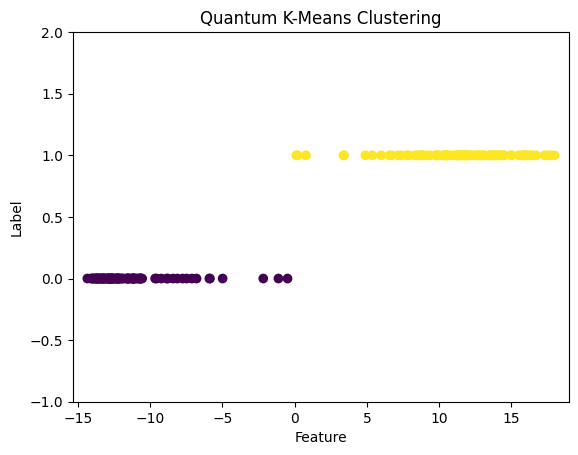

Quantum ARI score: 0.9602


In [16]:
# Choosing the number of centers
k = 2

# Getting the satellite data that was preprocessed in the previous notebook
# The actual labels of the data, for example Forest, Lake, ...
csv_path1 = '/Path/to/your/EuroSAT_RGB.csv'
actual_labels = pd.read_csv(csv_path1).iloc[:,-1].values

# The features of the images that will be clustered
csv_path2 = '/Path/to/your/EuroSAT_RGB_PCA.csv'
data2 = pd.read_csv(csv_path2)
# Getting the features
points = data2.values

# Initial guess for the centroids
centroids = initial_centers(points, k)

# Running the quantum k-means algorithm
# Finding the cluster for each vector based on the distance and the updating the centroids
# This part can be run as many times as necessary. The number of iterations can silghtly affect the results
for i in range(15):
    pred_labels = find_nearest_cluster(points, centroids)
    centroids = get_centroids(points, pred_labels)
    print(i)    # This helps the tracking of the algorithm, how many rounds are still left and if all of the centroids still exist
    print(f"Iteration {i}:")
    print(f"Centroids:\n{centroids}")
    print(f"Unique labels: {np.unique(pred_labels)}")
# Plotting the final clusters, x-axis is one of the features and y-axis is the label of the cluster
plt.figure()
plotting(points, pred_labels)

# Evaluating the performance of the clustering by finding the most common label in each cluster and mapping it to the corresponding actual label
# The variables can be added based on how many clusters there are
cluster_0_labels = actual_labels[pred_labels == 0]
cluster_1_labels = actual_labels[pred_labels==1]
# cluster_2_labels = actual_labels[pred_labels==2]
# cluster_3_labels = actual_labels[pred_labels==3]
# cluster_4_labels = actual_labels[pred_labels==4]
# cluster_5_labels = actual_labels[pred_labels==5]
# cluster_6_labels = actual_labels[pred_labels==6]
# cluster_7_labels = actual_labels[pred_labels==7]
# cluster_8_labels = actual_labels[pred_labels==8]
# cluster_9_labels = actual_labels[pred_labels==9]

cluster_0_majority = Counter(cluster_0_labels).most_common(1)[0][0]
cluster_1_majority = Counter(cluster_1_labels).most_common(1)[0][0]
# cluster_2_majority = Counter(cluster_2_labels).most_common(1)[0][0]
# cluster_3_majority = Counter(cluster_3_labels).most_common(1)[0][0]
# cluster_4_majority = Counter(cluster_4_labels).most_common(1)[0][0]
# cluster_5_majority = Counter(cluster_5_labels).most_common(1)[0][0]
# cluster_6_majority = Counter(cluster_6_labels).most_common(1)[0][0]
# cluster_7_majority = Counter(cluster_7_labels).most_common(1)[0][0]
# cluster_8_majority = Counter(cluster_8_labels).most_common(1)[0][0]
# cluster_9_majority = Counter(cluster_9_labels).most_common(1)[0][0]

cluster_label_mapping = {
    0: cluster_0_majority,
    1: cluster_1_majority,
    # 2: cluster_2_majority,
    # 3: cluster_3_majority,
    # 4: cluster_4_majority,
    # 5: cluster_5_majority,
    # 6: cluster_6_majority,
    # 7: cluster_7_majority,
    # 8: cluster_8_majority,
    # 9: cluster_9_majority

}

predicted_labels = np.array([cluster_label_mapping[label] for label in pred_labels])

# Calculating and printing the ARI score to see how well the model performed
score_quantum = adjusted_rand_score(actual_labels, predicted_labels)
print(f"Quantum ARI score: {score_quantum}")

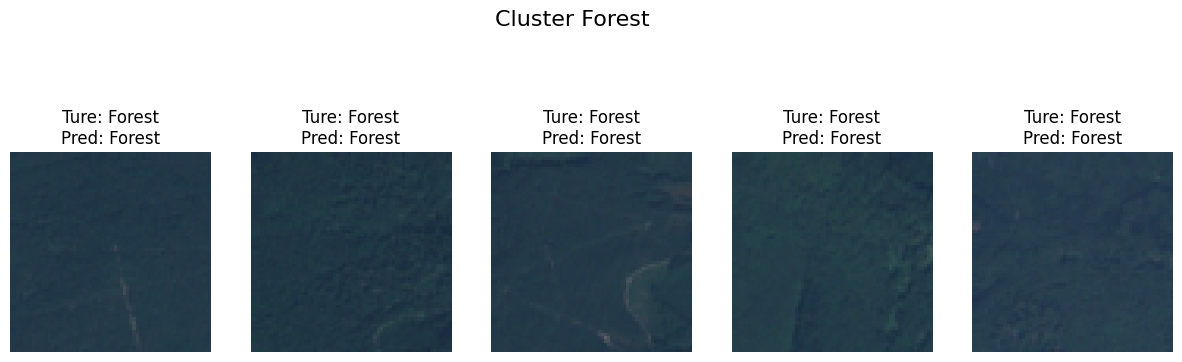

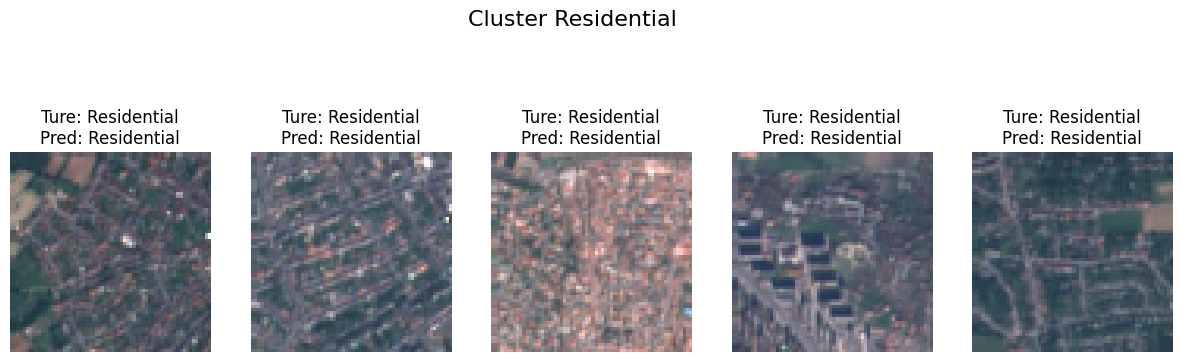

In [13]:
# This cell is for plotting some of the images in each cluster.
# It will show a few examples from each cluster and tell the actual label and the predicted label of the image

image_paths = pd.read_csv(csv_path1)['image_path'].values

# Function to get a sample image from each cluster
def samples(cluster_labels, num_samples=5):
    cluster_samples = {}
    for cluster in set(cluster_labels):
        cluster_indices = [i for i, label in enumerate(cluster_labels) if label == cluster]
        if len(cluster_indices) < num_samples:
            sampled_indices = cluster_indices
        else:
            sampled_indices = random.sample(cluster_indices, num_samples)
        cluster_samples[cluster] = sampled_indices
    return cluster_samples

num_samples_per_cluster = 5
cluster_samples = samples(predicted_labels, num_samples_per_cluster)

# Function for plotting the images
def plot_samples(cluster_samples, image_paths, true_labels, cluster_labels):
    for cluster, indices in cluster_samples.items():
        plt.figure(figsize=(15, 5))
        plt.suptitle(f'Cluster {cluster}', fontsize=16)
        for i, idx in enumerate(indices):
            image_path = image_paths[idx]
            true_label = true_labels[idx]
            pred_label = cluster_labels[idx]

            image = Image.open(image_path)
            
            plt.subplot(1, len(indices), i+1)
            plt.imshow(image)
            plt.title(f'True: {true_label}\nPred: {pred_label}')
            plt.axis('off')
        plt.show()

plot_samples(cluster_samples, image_paths, actual_labels, predicted_labels)

## 7. Comparing our algorithm with the Scikit-learn's k-means algorithm

In this last section we clsuter the same data with Scikit-learn's k-means algorithm. This step is done to see how the quantum implementation compares to the classical one.

0.9602


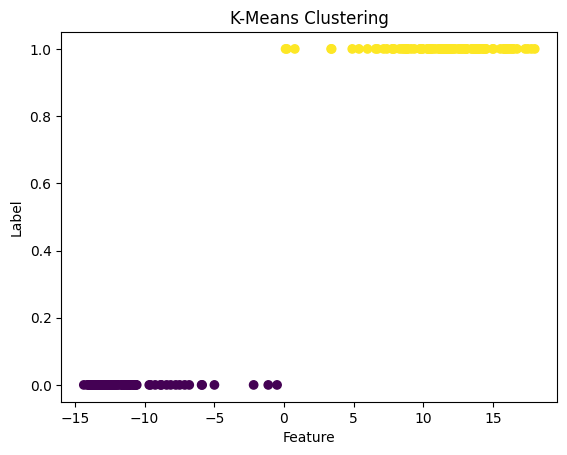

In [14]:
# Running the classical implementation of the k-means algorithm and plotting the results
# The ARI score is calculated again to compare the results of the quantum and the classical algorithm

kmeans = KMeans(n_clusters=k, random_state=42)
predicted = kmeans.fit_predict(points)

score_classical = adjusted_rand_score(actual_labels, predicted)

print(score_classical)
plt.scatter(points[:,0], predicted, c=predicted, cmap='viridis')
plt.title('K-Means Clustering')
plt.xlabel('Feature')
plt.ylabel('Label')
plt.show()

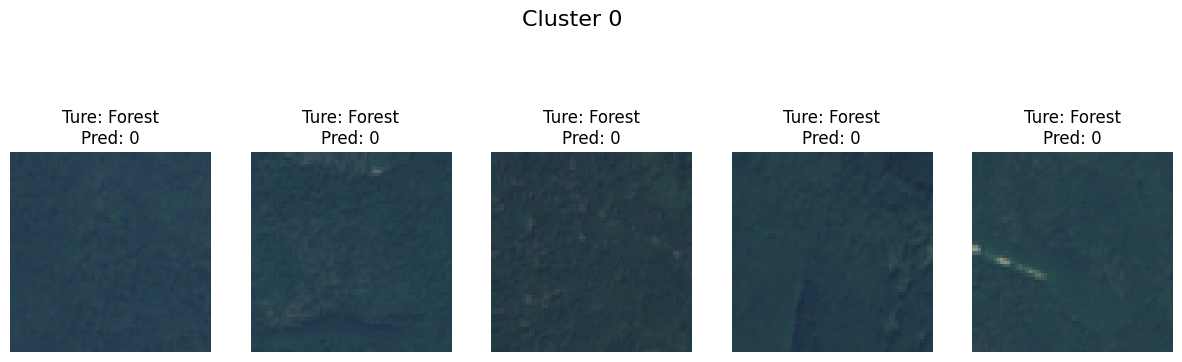

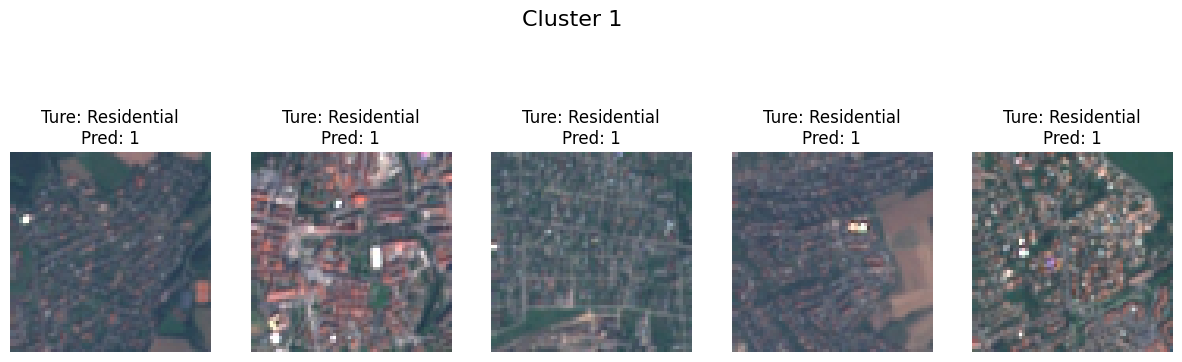

In [15]:
# The same function from before can be used to plot some of the clustered images and to see their actual and predicted labels

cluster_samples2 = samples(predicted, num_samples_per_cluster)
plot_samples(cluster_samples2, image_paths, actual_labels, predicted)

## References:

[1] [P. Helber, B. Bischke, A. Dengel, and D. Borth, EuroSAT: A Novel Dataset and Deep Learning Benchmark for Land Use and Land Cover Classification, Jul. 2018.](https://zenodo.org/records/7711810)

[2] [D. Kopczyk, Quantum machine learning for data scientists, Apr. 2018.](http://arxiv.org/abs/1804.10068)

[3] [S. U. Khan, A. J. Awan, and G. Vall-Llosera, K-Means Clustering on Noisy Intermediate Scale Quantum Computers, Sep. 2019.](http://arxiv.org/abs/1909.12183)

[4] [E. Aïmeur, G. Brassard, and S. Gambs, “Machine Learning in a Quantum World,” in Advances in Artificial Intelligence, Springer Berlin Heidelberg, 2006, pp. 431–442.](http://link.springer.com/10.1007/11766247_37)

[5] [Adjusted_rand_score, scikit-learn.](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.rand_score.html#rbedd61930922-1)

## Acknowledgement

- The classical functions for the quantum k-means algorithm are modified based on the code available in [this GitHub](https://github.com/smit14/Quantum-K-means-algorithm/blob/master/k_means_quantum.ipynb)
- The amplitude encoding function is modified from the code presented in [this blog post by Qiskit](https://medium.com/qiskit/calculate-quantum-euclidean-distance-with-qiskit-df85525ab485)
- Thank you for their important contribution!

